## Import

In [1]:
from network.neural_network import NeuralNetwork
from network.neural_network_utility import evaluate
from math_functions.function_enums import LossFunction, ActivationFunction, Metrics
from utilities.dataset_reader import read_monk, read_cup, read_old_cup
from model_selection.validation import kfold_cv, holdout, kfold_cv_ensemble
from model_selection.grid import grid_search, get_top_n_results, get_all_results
from utilities.utils import count_configs, save_top_plots, get_list_models, plot_over_epochs, get_ensemble_models
from network.ensemble import Ensemble
import numpy as np
import json

## Save training data and internal test data

In [ ]:
# data, targets = read_cup('datasets/cup/CUP_TR.csv')
# train_data, test_data, train_targets, test_targets = holdout(data, targets, 0.8, shuffle_set=True)

# np.savetxt(MODEL_SEL_DATA_PATH, train_data, delimiter=',')
# np.savetxt(MODEL_SEL_TARGETS_PATH, train_targets, delimiter=',')
# np.savetxt(MODEL_ASSESS_DATA_PATH, test_data, delimiter=',')
# np.savetxt(MODEL_ASSESS_TARGETS_PATH, test_targets, delimiter=',')

## Load training data and internal test data

In [2]:
MODEL_SEL_DATA_PATH = 'datasets/cup/grid_search/CUP_model_selection_data.csv'
MODEL_SEL_TARGETS_PATH = 'datasets/cup/grid_search/CUP_model_selection_targets.csv'
MODEL_ASSESS_DATA_PATH = 'datasets/cup/grid_search/CUP_model_assessment_data.csv'
MODEL_ASSESS_TARGETS_PATH = 'datasets/cup/grid_search/CUP_model_assessment_targets.csv'

In [3]:
train_data = np.loadtxt(MODEL_SEL_DATA_PATH, delimiter=',')
train_targets = np.loadtxt(MODEL_SEL_TARGETS_PATH, delimiter=',')
test_data = np.loadtxt(MODEL_ASSESS_DATA_PATH, delimiter=',')
test_targets = np.loadtxt(MODEL_ASSESS_TARGETS_PATH, delimiter=',')

## Hyperparameter tuning

In [4]:
fixed_params = dict(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    classification=False, 
    early_stopping=True, 
    fast_stopping=False,
    patience=20, 
    tolerance=0.1,
    epochs=500,
    linear_decay=True,
    verbose=False,
)

grid_params = dict(
    batch_size=[1, 64, 128],
    hidden_layer_sizes=[[64, 32], [128, 64], [128, 128], [64, 64, 32]],
    learning_rate=[0.0005, 0.005, 0.05, 0.1],
    mom_alpha=[0, 0.6, 0.7, 0.9],
    reg_lambda=[0, 0.0001, 0.00001],
    nesterov=[True, False],
    tao=[200, 500]
)

results = grid_search(
    k_folds=3, 
    data=train_data, 
    target=train_targets, 
    metrics=[Metrics.MSE.value, Metrics.MEE.value], 
    fixed_param=fixed_params, 
    grid_param=grid_params, 
    file_name_results="ml_cup_first_grid_full", 
    verbose=False,
    plot=True,
    log_scale=True
)

100%|██████████| 768/768 [8:52:35<00:00, 41.61s/it]  


#### Examining results

In [31]:
top_100_merged = get_top_n_results('ml_cup_first_grid_full.json', 100, 'validation_mee_mean', ascending=True)
top_50_merged = get_top_n_results('ml_cup_first_grid_full.json', 50, 'validation_mee_mean', ascending=True)
top_20_merged = get_top_n_results('ml_cup_first_grid_full.json', 20, 'validation_mee_mean', ascending=True)

In [33]:
results = get_all_results('ml_cup_first_grid_full.json')
print(f'total number of explored configs: {len(results)}')

validation_mee_means = {model[0]: model[1]['validation_mee_mean'] for model in top_100_merged}

for model_config, mee_mean in validation_mee_means.items():
    print(f"{model_config}: {mee_mean}")

total number of explored configs: 2304
batch_size: 64; hidden_layer_sizes: [128, 128]; learning_rate: 0.1; mom_alpha: 0.9; reg_lambda: 0; nesterov: False; tao: 500: 0.7154765680987968
batch_size: 1; hidden_layer_sizes: [128, 128]; learning_rate: 0.005; mom_alpha: 0.7; reg_lambda: 0; nesterov: True; tao: 500: 0.7419609846945789
batch_size: 1; hidden_layer_sizes: [128, 128]; learning_rate: 0.005; mom_alpha: 0.6; reg_lambda: 0; nesterov: False; tao: 500: 0.7440397390461252
batch_size: 1; hidden_layer_sizes: [128, 128]; learning_rate: 0.005; mom_alpha: 0.6; reg_lambda: 0; nesterov: True; tao: 500: 0.745788525360421
batch_size: 1; hidden_layer_sizes: [128, 128]; learning_rate: 0.005; mom_alpha: 0.6; reg_lambda: 1e-05; nesterov: True; tao: 500: 0.7461281733837245
batch_size: 1; hidden_layer_sizes: [128, 128]; learning_rate: 0.005; mom_alpha: 0.7; reg_lambda: 1e-05; nesterov: False; tao: 500: 0.7542952696222641
batch_size: 1; hidden_layer_sizes: [128, 64]; learning_rate: 0.005; mom_alpha: 0.7

In [34]:
print('TOP-100----------------')
count_configs(top_100_merged)
print('\nTOP-50----------------')
count_configs(top_50_merged)
print('\nTOP-20----------------')
count_configs(top_20_merged)

TOP-100----------------
batch_size:
  64: 26
  1: 65
  128: 9
hidden_layer_sizes:
  [128, 128]: 36
  [128, 64]: 26
  [64, 64, 32]: 19
  [64, 32]: 19
learning_rate:
  0.1: 26
  0.005: 59
  0.05: 9
  0.0005: 6
mom_alpha:
  0.9: 35
  0.7: 30
  0.6: 23
  0: 12
reg_lambda:
  0: 59
  1e-05: 24
  0.0001: 17
nesterov:
  False: 46
  True: 54
tao:
  500: 86
  200: 14

TOP-50----------------
batch_size:
  64: 12
  1: 32
  128: 6
hidden_layer_sizes:
  [128, 128]: 23
  [128, 64]: 16
  [64, 64, 32]: 7
  [64, 32]: 4
learning_rate:
  0.1: 12
  0.005: 31
  0.05: 6
  0.0005: 1
mom_alpha:
  0.9: 19
  0.7: 16
  0.6: 12
  0: 3
reg_lambda:
  0: 30
  1e-05: 12
  0.0001: 8
nesterov:
  False: 24
  True: 26
tao:
  500: 46
  200: 4

TOP-20----------------
batch_size:
  64: 4
  1: 13
  128: 3
hidden_layer_sizes:
  [128, 128]: 11
  [128, 64]: 7
  [64, 64, 32]: 2
learning_rate:
  0.1: 6
  0.005: 13
  0.05: 1
mom_alpha:
  0.9: 7
  0.7: 7
  0.6: 6
reg_lambda:
  0: 12
  1e-05: 4
  0.0001: 4
nesterov:
  False: 12
  Tru

In [11]:
save_top_plots(top_20, 'ml_cup_first_grid', 'ml_cup_first_grid_top_20')

training on best model for 64 batch_size version

### Second grid on batch size 64

batch_size 64 grid

In [35]:
fixed_params = dict(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    classification=False, 
    early_stopping=True, 
    fast_stopping=False,
    patience=20, 
    tolerance=0.1,
    epochs=2000,
    linear_decay=True,
    batch_size=64,
    hidden_layer_sizes=[128, 128],
    nesterov=True,
    verbose=False,
)

grid_params = dict(
    learning_rate=[0.02, 0.04, 0.05, 0.08, 0.1, 0.2],
    mom_alpha=[0, 0.6, 0.7, 0.9],
    reg_lambda=[0, 0.00001],
    tao=[500, 1000]
)

results = grid_search(
    k_folds=5, 
    data=train_data, 
    target=train_targets, 
    metrics=[Metrics.MSE.value, Metrics.MEE.value], 
    fixed_param=fixed_params, 
    grid_param=grid_params, 
    file_name_results="ml_cup_second_grid_batch_64", 
    verbose=False,
    plot=True,
    log_scale=True
)

100%|██████████| 96/96 [13:12:12<00:00, 495.13s/it]  


### Second grid on batch_size 1

batch_size 1 grid

In [ ]:
fixed_params = dict(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    classification=False, 
    early_stopping=True, 
    fast_stopping=False,
    patience=20, 
    tolerance=0.1,
    epochs=2000,
    linear_decay=True,
    batch_size=1,
    hidden_layer_sizes=[128, 128],
    nesterov=False,
    verbose=False,
)

grid_params = dict(
    learning_rate=[0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008],
    mom_alpha=[0.5, 0.6, 0.7],
    reg_lambda=[0, 0.0001, 0.00001, 0.00005],
    tao=[500, 1000]
)

results = grid_search(
    k_folds=5, 
    data=train_data, 
    target=train_targets, 
    metrics=[Metrics.MSE.value, Metrics.MEE.value], 
    fixed_param=fixed_params, 
    grid_param=grid_params, 
    file_name_results="ml_cup_second_grid_batch_1", 
    verbose=False,
    plot=True,
    log_scale=True
)

### Results examination

In [17]:
top_100_second_batch_64 = get_top_n_results('ml_cup_second_grid_batch_64.json', 100, 'validation_mee_mean', ascending=True)
top_50_second_batch_64 = get_top_n_results('ml_cup_second_grid_batch_64.json', 50, 'validation_mee_mean', ascending=True)
top_20_second_batch_64 = get_top_n_results('ml_cup_second_grid_batch_64.json', 20, 'validation_mee_mean', ascending=True)

In [38]:
results = get_all_results('ml_cup_second_grid_batch_64.json')
print(f'total number of explored configs: {len(results)}')

validation_mee_means = {model[0]: model[1]['validation_mee_mean'] for model in top_100_second_batch_64}

for model_config, mee_mean in validation_mee_means.items():
    print(f"{model_config}: {mee_mean}")

total number of explored configs: 96
learning_rate: 0.2; mom_alpha: 0.7; reg_lambda: 0; tao: 1000: 0.6003694811361622
learning_rate: 0.08; mom_alpha: 0.9; reg_lambda: 0; tao: 1000: 0.6042017933029158
learning_rate: 0.08; mom_alpha: 0.9; reg_lambda: 0; tao: 500: 0.6478211690575787
learning_rate: 0.04; mom_alpha: 0.9; reg_lambda: 0; tao: 1000: 0.654818198410873
learning_rate: 0.1; mom_alpha: 0.7; reg_lambda: 0; tao: 1000: 0.6570708456759368
learning_rate: 0.1; mom_alpha: 0.9; reg_lambda: 0; tao: 500: 0.6621546623019582
learning_rate: 0.05; mom_alpha: 0.9; reg_lambda: 0; tao: 1000: 0.6628410870486051
learning_rate: 0.2; mom_alpha: 0.6; reg_lambda: 0; tao: 1000: 0.6723628115401941
learning_rate: 0.2; mom_alpha: 0.7; reg_lambda: 0; tao: 500: 0.6823861092812891
learning_rate: 0.05; mom_alpha: 0.9; reg_lambda: 0; tao: 500: 0.6886046465394321
learning_rate: 0.2; mom_alpha: 0.6; reg_lambda: 0; tao: 500: 0.7128370930049155
learning_rate: 0.1; mom_alpha: 0.6; reg_lambda: 0; tao: 1000: 0.716522832

In [42]:
save_top_plots(top_20, 'ml_cup_second_grid_batch_64', 'ml_cup_second_grid_batch_64_top_20')

In [39]:
top_100_second_batch_1 = get_top_n_results('ml_cup_second_grid_batch_1.json', 100, 'validation_mee_mean', ascending=True)
top_50_second_batch_1 = get_top_n_results('ml_cup_second_grid_batch_1.json', 50, 'validation_mee_mean', ascending=True)
top_20_second_batch_1 = get_top_n_results('ml_cup_second_grid_batch_1.json', 20, 'validation_mee_mean', ascending=True)

In [40]:
results = get_all_results('ml_cup_second_grid_batch_1.json')
print(f'total number of explored configs: {len(results)}')

validation_mee_means = {model[0]: model[1]['validation_mee_mean'] for model in top_100_second_batch_1}

for model_config, mee_mean in validation_mee_means.items():
    print(f"{model_config}: {mee_mean}")

total number of explored configs: 168
learning_rate: 0.006; mom_alpha: 0.6; reg_lambda: 5e-05; tao: 1000: 0.5819151429699669
learning_rate: 0.006; mom_alpha: 0.5; reg_lambda: 0; tao: 1000: 0.5832515290762237
learning_rate: 0.008; mom_alpha: 0.5; reg_lambda: 0; tao: 1000: 0.5923547052125778
learning_rate: 0.003; mom_alpha: 0.7; reg_lambda: 1e-05; tao: 1000: 0.6004877143204503
learning_rate: 0.005; mom_alpha: 0.6; reg_lambda: 1e-05; tao: 1000: 0.6036657313571299
learning_rate: 0.005; mom_alpha: 0.5; reg_lambda: 5e-05; tao: 1000: 0.6079996637864811
learning_rate: 0.004; mom_alpha: 0.7; reg_lambda: 1e-05; tao: 1000: 0.6087637930057059
learning_rate: 0.005; mom_alpha: 0.5; reg_lambda: 0; tao: 1000: 0.6099392365246453
learning_rate: 0.007; mom_alpha: 0.5; reg_lambda: 1e-05; tao: 1000: 0.6107534529572654
learning_rate: 0.005; mom_alpha: 0.7; reg_lambda: 1e-05; tao: 1000: 0.6111054554454085
learning_rate: 0.006; mom_alpha: 0.5; reg_lambda: 5e-05; tao: 1000: 0.6113887322332971
learning_rate: 0.

### Try on the top model for the 64 batch_size version

we plot on the internal test set (no operation is done with the internal test set, it's just a plot)

In [61]:
net = NeuralNetwork(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    classification=False, 
    early_stopping=False, 
    fast_stopping=False,
    patience=20, 
    tolerance=0.1,
    epochs=2000,
    linear_decay=True,
    batch_size=1,
    hidden_layer_sizes=[128, 128],
    nesterov=True,
    learning_rate=0.006,
    mom_alpha=0.6,
    reg_lambda=0.00005,
    tao=1000,
    verbose=False
)

net.train_net(train_data=train_data, train_target=train_targets, val_data=test_data, val_target=test_targets, tr_loss_stopping_point=0.07113932071043247)
net.predict_and_evaluate(test_data, test_targets, Metrics.MEE.value)

0.4677732569711591

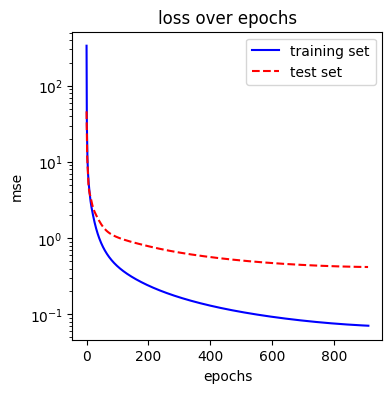

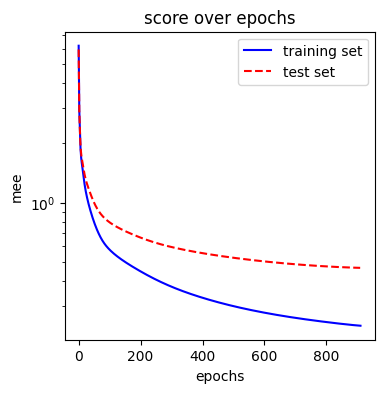

In [64]:
plot_over_epochs(y_values=net.training_losses, title='loss over epochs', y_label='mse', y_legend='training set', y_prime_values=net.validation_losses, y_prime_legend='test set', yscale='log')
plot_over_epochs(y_values=net.training_evaluations, title='score over epochs', y_label='mee', y_legend='training set', y_prime_values=net.validation_evaluations, y_prime_legend='test set', yscale='log')

## Ensemble

After picking the best 10 performing models, we decided to build an ensamble in order to improve performance.

Note: we won't train the models using early stopping right now. We will use more data to train the models and use the training loss mean of the best epoch (w.r.t. the internal valiation loss) obtained during the kfold cv in the grid process.

In [4]:
# get top 10 results from both batches grids
top_10_second_batch_1 = get_top_n_results('ml_cup_second_grid_batch_1.json', 10, 'validation_mee_mean', ascending=True)
top_10_second_batch_64 = get_top_n_results('ml_cup_second_grid_batch_64.json', 10, 'validation_mee_mean', ascending=True)

# merge them together and sort by validation_mee_mean
merged_data = top_10_second_batch_1 + top_10_second_batch_64
sorted_data = sorted(merged_data, key=lambda x: x[1]['validation_mee_mean'])

# get the final top 10 results
top_10_models_results = sorted_data[:10]

# get the stopping point for training the retrained model over the entire development dataset
tr_stopping_points = [results[1]['tr_losses_mean'] for results in top_10_models_results]

# get the top 10 models configurations
list_models = get_list_models(top_10_models_results)

first we execute a kfold over the ensemble (and over each constituent model)

In [5]:
fixed_params = dict(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    epochs=2000, 
    nesterov=False, 
    classification=False, 
    early_stopping=False, 
    fast_stopping=False,
    linear_decay=True,
    patience=20, 
    tolerance=0.1,
    hidden_layer_sizes=[128, 128],
    verbose=False
)

# build ensemble
models = []
for index, model in enumerate(list_models):
    params = {**fixed_params, **model}
    models.append(NeuralNetwork(**fixed_params, **model))
ensemble = Ensemble(models)

# cross-validation on ensemble
kfold_model_result, kfold_ensemble_result = kfold_cv_ensemble(5, train_data, train_targets, [Metrics.MSE.value, Metrics.MEE.value], ensemble, tr_stopping_points=tr_stopping_points, verbose=False)

with open('json_results/ensemble_top_10.json', 'w', encoding='utf-8') as f:
    json.dump({**kfold_model_result, **kfold_ensemble_result}, f, indent=4)

## Model Selection and Model Assessment

Results on the kfold cross validation has shown that the best performing model is indeed the ensemble of the top 10 models. Thus we now retrain the model on the entire internal training set

In [6]:
fixed_params = dict(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    epochs=2000, 
    nesterov=False, 
    classification=False, 
    early_stopping=False, 
    fast_stopping=False,
    linear_decay=True,
    patience=20, 
    tolerance=0.1,
    hidden_layer_sizes=[128, 128],
    verbose=False
)

# build ensemble
models = []
for index, model in enumerate(list_models):
    params = {**fixed_params, **model}
    models.append(NeuralNetwork(**fixed_params, **model))
ensemble = Ensemble(models)

# train ensemble on the entire development dataset
ensemble.train(train_data, train_targets, test_data, test_targets, tr_stopping_points=tr_stopping_points)

# evaluate ensemble on the test set and save results
results = {}
for index, model in enumerate(ensemble.models):
    y_pred = model.predict(test_data)
    results[f"model_{index+1}"] = evaluate(y_pred, test_targets, Metrics.MEE.value)
    
y_pred = ensemble.predict(test_data)
results["ensemble"] = evaluate(y_pred, test_targets, Metrics.MEE.value)

with open('json_results/ensemble_top_10_test_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=4) 


Now we will proceede with the model assessment by training and testing over the internal test set multiple times, to then average the results (in order to achieve a less biased result)

In [7]:
fixed_params = dict(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    epochs=2000, 
    nesterov=False, 
    classification=False, 
    early_stopping=False, 
    fast_stopping=False,
    linear_decay=True,
    patience=20, 
    tolerance=0.1,
    hidden_layer_sizes=[128, 128],
    verbose=False
)

results = []

for i in range(5):
    # build ensemble
    models = []
    for index, model in enumerate(list_models):
        params = {**fixed_params, **model}
        models.append(NeuralNetwork(**fixed_params, **model))
    ensemble = Ensemble(models)

    # train ensemble on the entire development dataset
    ensemble.train(train_data, train_targets, test_data, test_targets, tr_stopping_points=tr_stopping_points)

        
    y_pred = ensemble.predict(test_data)
    results.append(evaluate(y_pred, test_targets, Metrics.MEE.value))

model_assessment = {}
model_assessment['test_results'] = results
model_assessment['test_mean'] = np.mean(results)
model_assessment['test_std'] = np.std(results)

with open('json_results/ensemble_top_10_model_assessment.json', 'w', encoding='utf-8') as f:
    json.dump(model_assessment, f, indent=4)

## Retraining the chosen model on the entire training set

Now that we assessed the model performance, we can retrain the model using the entire training set.

Note: we use the mean training loss obtained at the best epoch (w.r.t. the validation loss) as stopping criteria for the training. In this way we assure that the same level of fitting is achieved.

In [ ]:
data, targets = read_cup('datasets/cup/CUP_TR.csv')

In [ ]:
fixed_params = dict(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    epochs=2000, 
    nesterov=False, 
    classification=False, 
    early_stopping=False, 
    fast_stopping=False,
    linear_decay=True,
    patience=20, 
    tolerance=0.1,
    hidden_layer_sizes=[128, 128],
    verbose=False
)

models = []
for index, model in enumerate(list_models):
    params = {**fixed_params, **model}
    models.append(NeuralNetwork(**fixed_params, **model))
ensemble = Ensemble(models)

# train ensemble on the entire development dataset
ensemble.train(data, targets, None, None, tr_stopping_points=tr_stopping_points)